# Clustering: Gamma Ray Bursts

## WIP - Unfinished!!!

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import sklearn
from sklearn.cluster import (KMeans, MeanShift, estimate_bandwidth)
from sklearn import preprocessing

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 12

In [21]:
#File fetch and read

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [22]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [23]:
data.T

array([['GRB230421A*', 'GRB230421405', '9:42:41.253', ..., '9.7280',
        'True', '60055.40464413'],
       ['GRB230420A', 'None', '10:19:01', ..., '111.7500', 'False',
        '60054.42987269'],
       ['GRB230419A*', 'GRB230419568', '13:37:43.335', ..., '0.2560',
        'True', '60053.56786267'],
       ...,
       ['GRB910424A*', 'None', '19:43:25.064', ..., '3.1360', 'False',
        '48370.82181787'],
       ['GRB910423A*', 'None', '19:51:15.804', ..., '208.5760', 'False',
        '48369.82726625'],
       ['GRB910421A*', 'None', '9:14:03.800', ..., '5.6960', 'False',
        '48367.38476620']], dtype='<U14')

## T90 vs Flux

In [24]:
#Column splicing

#They're read as strings!!! Converting is mandatory
T90 = np.array(data[6, :], dtype=float)
flux = np.array(data[9, :], dtype=float)



In [103]:
#Filtering good data
filter = (T90 > 0) & (flux > 0)     #Mask

T90clean = T90[filter]
flux_clean = flux[filter]

[]

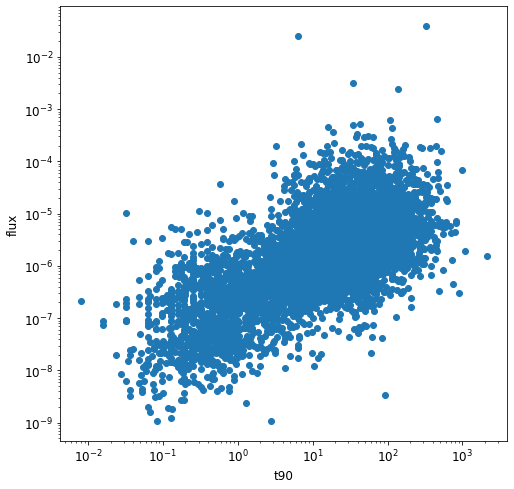

In [104]:
plt.scatter(T90clean, flux_clean)
plt.xlabel('t90')
plt.ylabel('flux')
plt.loglog()


### K-means clustering with 2 n_clusters

In [115]:
#Reshaping, sklearn is picky!!

print(T90clean.shape)
print(flux_clean.shape)

new_T90clean = T90clean[:, np.newaxis]
new_flux_clean = flux_clean[:, np.newaxis]

print(new_T90clean.shape)
print(new_flux_clean.shape)

#Constructing the dataset, formatted as sklearn input (rows[n_samples] x columns[1])
to_fit = np.column_stack([new_T90clean, new_flux_clean])
to_fit.shape


(6975,)
(6975,)
(6975, 1)
(6975, 1)


(6975, 2)

In [118]:
#KMeans Cluster initialization
cluster = KMeans(n_clusters=2)

#Since I then plot in loglog, I transform input data in loglog form

to_fit = np.log(to_fit)
to_fit.shape


(6975, 2)

In [119]:

#Training the model
cluster.fit(to_fit)

#Clusters positions
centers = cluster.cluster_centers_

#Labels characterizing each cluster
labels = cluster.predict(to_fit)

print(centers.shape)
print(labels.shape)

(2, 2)
(6975,)


Text(0.5, 1.0, 'Clustering output')

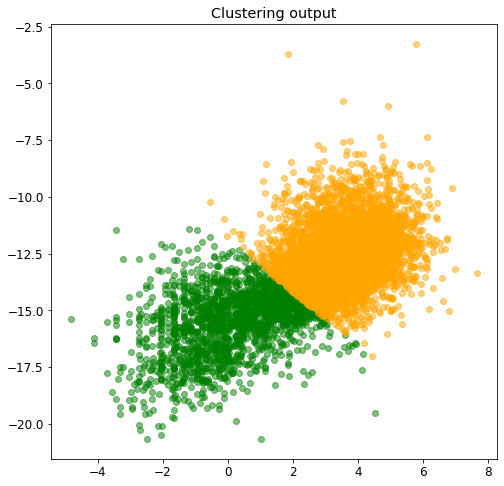

In [122]:
# plot the data color-coded by cluster id

colors = ['green', 'orange']
for i in range(2):
    plt.scatter(x=to_fit[labels==i,0], y=to_fit[labels==i,1], 
                color=colors[i],alpha=0.5)


#Because of the way in which I trained the cluster, the plot is already in loglog
#plt.loglog()

plt.title('Clustering output')

### K-means clustering with 4 n_clusters

In [123]:
#Reshaping, sklearn is picky!!

print(T90clean.shape)
print(flux_clean.shape)

new_T90clean = T90clean[:, np.newaxis]
new_flux_clean = flux_clean[:, np.newaxis]

print(new_T90clean.shape)
print(new_flux_clean.shape)

#Constructing the dataset, formatted as sklearn input (rows[n_samples] x columns[1])
to_fit = np.column_stack([new_T90clean, new_flux_clean])
to_fit.shape


(6975,)
(6975,)
(6975, 1)
(6975, 1)


(6975, 2)

In [124]:
#KMeans Cluster initialization
cluster = KMeans(n_clusters=4)

#Since I then plot in loglog, I transform input data in loglog form

to_fit = np.log(to_fit)
to_fit.shape


(6975, 2)

In [125]:

#Training the model
cluster.fit(to_fit)

#Clusters positions
centers = cluster.cluster_centers_

#Labels characterizing each cluster
labels = cluster.predict(to_fit)

print(centers.shape)
print(labels.shape)

(4, 2)
(6975,)


Text(0.5, 1.0, 'Clustering output')

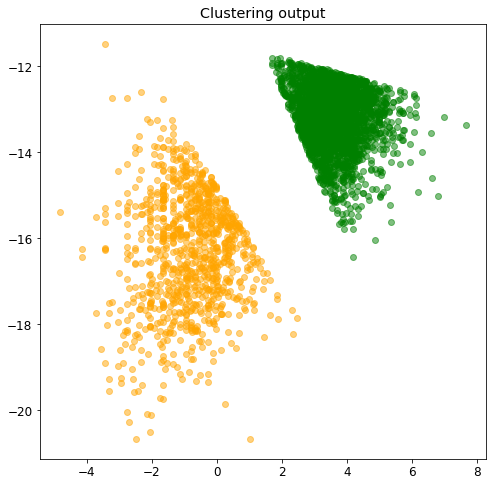

In [127]:
# plot the data color-coded by cluster id

colors = ['green', 'orange', 'red', 'blue']
for i in range(2):
    plt.scatter(x=to_fit[labels==i,0], y=to_fit[labels==i,1], 
                color=colors[i],alpha=0.5)


#Because of the way in which I trained the cluster, the plot is already in loglog
#plt.loglog()

plt.title('Clustering output')

### Mean-Shift Clustering

In [139]:
# Compute the Mean-shift clustering


scaler = preprocessing.StandardScaler()

#Manually setting the bandwitdh
#bandwidth = 1

#Exploiting implemented technique to estimate best bandwith, for large dataset is slow!
bandwidth = estimate_bandwidth(to_fit)

ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=True)
ms.fit(to_fit)
#ms.fit(scaler.fit_transform(to_fit))

labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])

print(labels_unique)
print('Bandwidth: ', bandwidth)
print("number of estimated clusters :", n_clusters)

[0 1 2]
Bandwidth:  2.1158614643466183
number of estimated clusters : 3


## Right Ascension vs Declination

In [140]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [141]:
ra = np.array(data[3, :], dtype=float)
dec = np.array(data[4, :], dtype=float)


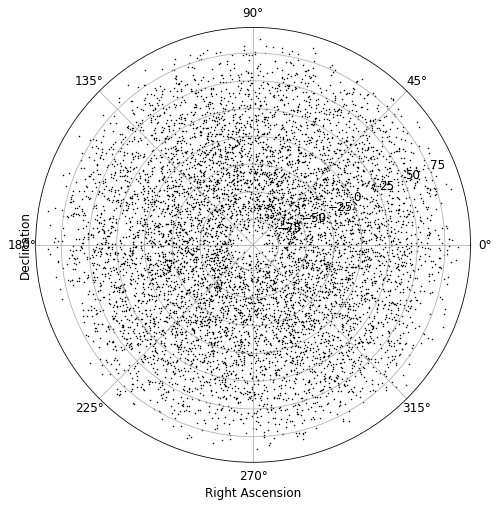

In [154]:
#Polar Plot
ax = plt.subplot(polar=True)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

'''
#Ticks position
angs = np.array([330., 345., 0., 15., 30., 45., 60., 75., 90., 105., 120.])
plt.xticks(angs * np.pi / 180., fontsize=8, c='red')
plt.yticks(np.arange(-80, -59, 10), fontsize=8, c='red')
ax.set_rlabel_position(120)
ax.set_xticklabels(['$22^h$', '$23^h$', '$0^h$', '$1^h$', '$2^h$', '$3^h$',
    '$4^h$', '$5^h$', '$6^h$', '$7^h$', '$8^h$'], fontsize=10)
ax.set_yticklabels(['$-80^{\circ}$', '$-70^{\circ}$', '$-60^{\circ}$'],
    fontsize=10, c='red')
'''


#Scatter points
ax.scatter(ra, dec, marker='o', c='k', s=1, lw=0.5)
plt.show()

(array([[   0.,   21., 1053.,  948., 1022., 1007., 1035., 1013., 1022.,
          994.],
        [1340., 2732., 2744., 1299.,    0.,    0.,    0.,    0.,    0.,
            0.]]),
 array([-89.0086 , -44.12274,   0.76312,  45.64898,  90.53484, 135.4207 ,
        180.30656, 225.19242, 270.07828, 314.96414, 359.85   ]),
 <a list of 2 BarContainer objects>)

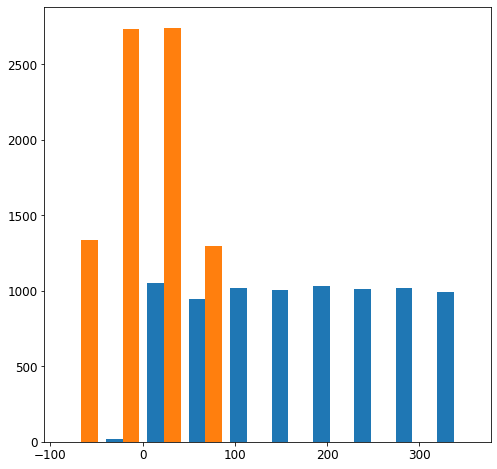

In [157]:
plt.hist([ra, dec])

In [155]:
to_fit = np.column_stack([ra, dec])

In [162]:
#Since there are no clear number of clusters -> Trying with the Mean-shift clustering


scaler = preprocessing.StandardScaler()

#Manually setting the bandwitdh
#bandwidth = 1

#Exploiting implemented technique to estimate best bandwith, for large dataset is slow!
bandwidth = estimate_bandwidth(to_fit)

ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=True)
ms.fit(to_fit)
#ms.fit(scaler.fit_transform(to_fit))

labels_unique = np.unique(ms.labels_)
ra_dec_clusters = len(labels_unique[labels_unique >= 0])

print(labels_unique)
print('Bandwidth: ', bandwidth)
print("number of estimated clusters :", n_clusters)


[0 1]
Bandwidth:  87.41002750911672
number of estimated clusters : 2


In [163]:
ra_dec_clusters

2

In [164]:
cluster = KMeans(n_clusters=ra_dec_clusters)

#Training the model
cluster.fit(to_fit)

#Clusters positions
centers = cluster.cluster_centers_

#Labels characterizing each cluster
labels = cluster.predict(to_fit)

print(centers.shape)
print(labels.shape)

(2, 2)
(8115,)


Text(0.5, 1.0, 'Clustering output')

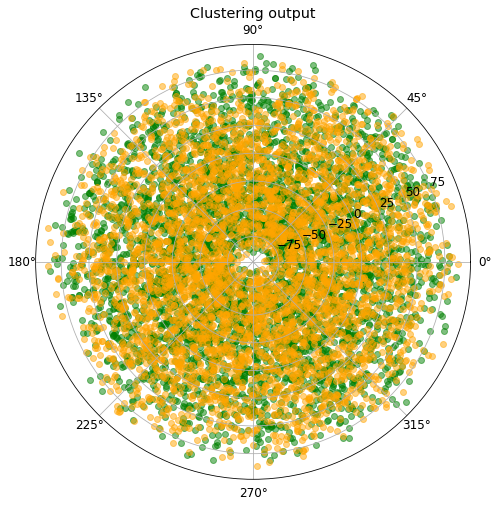

In [166]:
# plot the data color-coded by cluster id

ax = plt.subplot(polar=True)


colors = ['green', 'orange', 'red', 'blue']
for i in range(2):
    ax.scatter(x=to_fit[labels==i,0], y=to_fit[labels==i,1], 
                color=colors[i],alpha=0.5)


#Because of the way in which I trained the cluster, the plot is already in loglog
#plt.loglog()

plt.title('Clustering output')

There is no clear separation between clusters, this analysis is leading nowhere (good sign?).

## 

In [169]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [173]:
redshift = np.array(data[11, :], dtype=float)

In [177]:
redshift.shape


(8115,)

In [180]:

red_flux_mask = (redshift >= 0) & (flux >= 0)

In [181]:
redshift_clean = redshift[red_flux_mask]
flux_clean = flux[red_flux_mask]


In [182]:
redshift_clean

array([9.0000e-02, 1.6640e+00, 6.5000e-02, 4.8400e-01, 2.1420e+00,
       3.8100e+00, 2.6940e+00, 4.0600e+00, 1.5100e-01, 3.0840e+00,
       1.2049e+00, 8.5700e-01, 5.6000e+00, 5.3000e-01, 4.9610e+00,
       1.2460e+00, 4.6180e+00, 2.2800e-01, 1.0800e-01, 2.2720e+00,
       1.1137e+00, 6.6070e-01, 3.9000e-01, 6.4000e-01, 2.4110e-01,
       5.0000e-02, 1.7360e+00, 1.2525e+00, 3.5000e-01, 1.1450e+00,
       1.2700e+00, 1.9370e+00, 1.1300e+00, 3.5400e+00, 3.5400e+00,
       2.4860e+00, 2.2100e-01, 2.0770e+00, 1.4000e+00, 2.8260e+00,
       4.2000e-01, 1.4870e+00, 2.1980e+00, 7.1500e-01, 1.1710e+00,
       2.0000e+00, 9.2000e-01, 1.0460e+00, 5.7000e+00, 1.1000e+00,
       1.1050e+00, 1.9540e+00, 9.9900e-01, 1.0700e+00, 8.0400e-01,
       2.9030e+00, 4.2600e-01, 4.5600e+00, 1.2500e+00, 7.4810e-01,
       7.3000e-01, 1.2268e+00, 1.2560e+00, 1.1480e+00, 2.4800e-01,
       1.7220e+00, 3.5030e+00, 7.8500e-02, 2.4690e+00, 1.9420e+00,
       1.1715e+00, 4.2000e-01, 3.3765e+00, 1.8590e+00, 2.4000e

In [183]:
flux_clean

array([9.1265e-06, 1.3000e-06, 3.1475e-03, 1.6000e-07, 7.1478e-05,
       8.1200e-07, 1.1402e-06, 5.1000e-07, 3.8836e-02, 4.5358e-05,
       6.7000e-07, 5.1774e-05, 9.1851e-07, 1.5550e-07, 1.6000e-06,
       1.8004e-05, 6.0375e-05, 8.0000e-06, 5.0118e-04, 1.9000e-07,
       6.8000e-06, 1.7000e-07, 9.3256e-05, 1.5335e-04, 8.8000e-08,
       1.2052e-05, 2.0000e-05, 3.0532e-06, 4.5000e-08, 4.3665e-06,
       4.0022e-05, 3.0248e-04, 1.1042e-04, 1.2845e-06, 7.3090e-07,
       1.5000e-07, 2.3152e-07, 2.7000e-06, 1.5000e-06, 1.2000e-06,
       1.0922e-06, 6.7000e-07, 3.4000e-07, 9.8000e-07, 7.5698e-05,
       2.3300e-05, 1.9137e-05, 6.3567e-07, 1.8000e-06, 1.3632e-04,
       2.4556e-06, 1.8000e-06, 8.1000e-07, 1.6782e-06, 3.4131e-05,
       1.5622e-06, 2.0000e-07, 3.1000e-07, 2.1351e-04, 4.2645e-06,
       1.8648e-06, 4.8873e-05, 1.3964e-05, 1.9000e-05, 1.0000e-05,
       8.5225e-07, 2.5000e-06, 1.5434e-05, 7.1179e-06, 9.9000e-08,
       1.6380e-05, 4.4325e-04, 8.0000e-07, 6.0000e-06, 1.5000e

[]

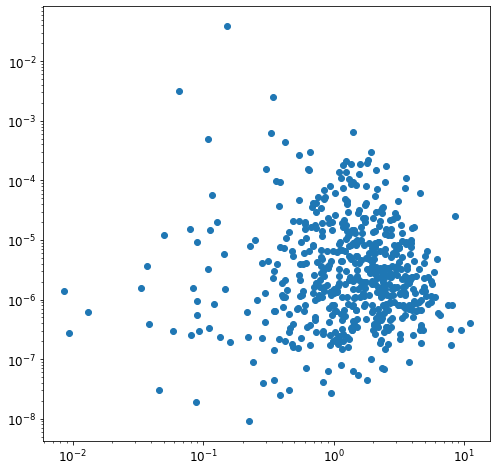

In [188]:
plt.scatter(redshift_clean, flux_clean)
plt.loglog()